<div><img src="http://www.stevinsonauto.net/assets/Icon_Brake.png", width=270, height=270, align = 'right'> 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:0px 25px"></div>

# Classifying Driver Type with Brake Events
##### By Rafi Kurlansik and Ross Lewis

________________________________

**Table of contents**
    
* [Problem Statement](#problemStatement)
    
* [Exploratory Data Analysis](#eda)

* [Modeling](#ml)
    
* [Data and Model Export](#export)

* [Conclusion](#conclusion)

______________________

<a id='problemStatement'></a>

### Problem Statement

The service bays at dealerships have seen an increase in warranty claims related to brakes.  Using historical telematics data of known driver types, can we classify the driving style of customers making warranty claims?

________
<a id='eda'></a>

### Exploratory Data Analysis

To do this we'll need to load and explore our historical data.  Switch to a Python kernel, run the following <b>!wget</b> cell, switch back to an R kernel, and continue

In [1]:
!wget https://raw.githubusercontent.com/rosswlewis/DSforAutomotive/master/historical_brake_eventsGM.csv

--2017-08-21 19:02:04--  https://raw.githubusercontent.com/rosswlewis/DSforAutomotive/master/historical_brake_eventsGM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153804 (150K) [text/plain]
Saving to: ‘historical_brake_eventsGM.csv’

historical_brake_ev 100%[=====================>] 150.20K  --.-KB/s   in 0.005s 

2017-08-21 19:02:04 (28.2 MB/s) - ‘historical_brake_eventsGM.csv’ saved [153804/153804]



In [1]:
brakeEventDF <- read.csv(file = 'historical_brake_eventsGM.csv')

In [2]:
head(brakeEventDF)

X,VIN,type,brake_time_sec,brake_distance_ft,road_type,braking_score,brake_pressure20pct,brake_pressure40pct,brake_pressure60pct,brake_pressure80pct,brake_pressure100pct,abs_event,travel_speed
368,1G1FX6S08H4000029,quality,7.87,90.04,highway,177,1,1,1,0,0,0,60
377,1G1FX6S08H4000030,quality,5.14,59.37,main road,141,0,0,0,0,0,0,46
406,1G1FX6S08H4000031,quality,4.45,27.09,residential,196,1,1,1,0,0,0,29
1326,1G1RB6E41FU000047,distracted,3.20,54.64,main road,149,1,1,0,0,0,1,42
2876,1G1RB6E41FU000034,aggressive,5.03,63.06,highway,114,1,1,1,1,0,0,72
1367,1G1RB6E41FU000048,distracted,3.00,33.29,residential,124,0,0,0,0,0,0,21


We see VINs, the type or classification of the brake event, and then a series of columns related to the brake event itself.  

#### Summary Statistics

Let's begin exploring the data by looking at some summary statistics of these events by both type and road type.

In [3]:
install.packages("magrittr")
library(magrittr)

Installing package into ‘/user-home/_global_/R’
(as ‘lib’ is unspecified)


In [4]:
install.packages("dplyr")
library(dplyr)

Installing package into ‘/user-home/_global_/R’
(as ‘lib’ is unspecified)
also installing the dependencies ‘bindr’, ‘bindrcpp’, ‘glue’, ‘pkgconfig’, ‘rlang’, ‘tibble’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:SparkR’:

    arrange, between, collect, contains, count, cume_dist, dense_rank,
    desc, distinct, explain, filter, first, group_by, intersect, lag,
    last, lead, mutate, n, n_distinct, ntile, percent_rank, rename,
    row_number, sample_frac, select, sql, summarize, union

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
print("Summary Statistics by Event Type")
group_by(brakeEventDF, type) %>% summarise(avg_braketime = mean(brake_time_sec), avg_brakedistance = mean(brake_distance_ft), avg_brakescore = mean(braking_score), abs_events = sum(abs_event))

print("Summary Statistics by Event Type and Road Type")
aggDF <- group_by(brakeEventDF, type, road_type) %>% summarise(avg_braketime = mean(brake_time_sec), avg_brakedistance = mean(brake_distance_ft), avg_brakescore = mean(braking_score), abs_events = sum(abs_event))

aggDF

[1] "Summary Statistics by Event Type"


type,avg_braketime,avg_brakedistance,avg_brakescore,abs_events
aggressive,3.160258,42.16379,99.34003,78
distracted,4.237135,54.42586,132.94444,336
quality,5.844743,60.11987,175.71627,5


[1] "Summary Statistics by Event Type and Road Type"


type,road_type,avg_braketime,avg_brakedistance,avg_brakescore,abs_events
aggressive,highway,4.938707,60.21241,98.84483,66
aggressive,main road,2.491429,44.95686,98.96327,9
aggressive,residential,2.029636,20.02023,100.28182,3
distracted,highway,5.462018,78.44654,130.47368,153
distracted,main road,3.995771,54.93868,134.56828,103
distracted,residential,3.256856,30.00175,133.79476,80
quality,highway,7.747718,89.95004,175.87967,5
quality,main road,5.771799,59.98008,176.02929,0
quality,residential,3.998787,30.17987,175.23849,0


Looks like aggressive drivers have lower brake times, distances, and scores.  Distracted drivers have more ABS events.  Quality drivers are on the other side of the spectrum.  

#### Visualization

We can see these relationships visually using the open source R package, ggplot2.  Let's examine the following three relationships:

* Brake Time by Type
* Brake Distance by Braking Score
* ABS Events by Type and Road Type

In [6]:
install.packages("ggplot2")
library(ggplot2)

Installing package into ‘/user-home/_global_/R’
(as ‘lib’ is unspecified)


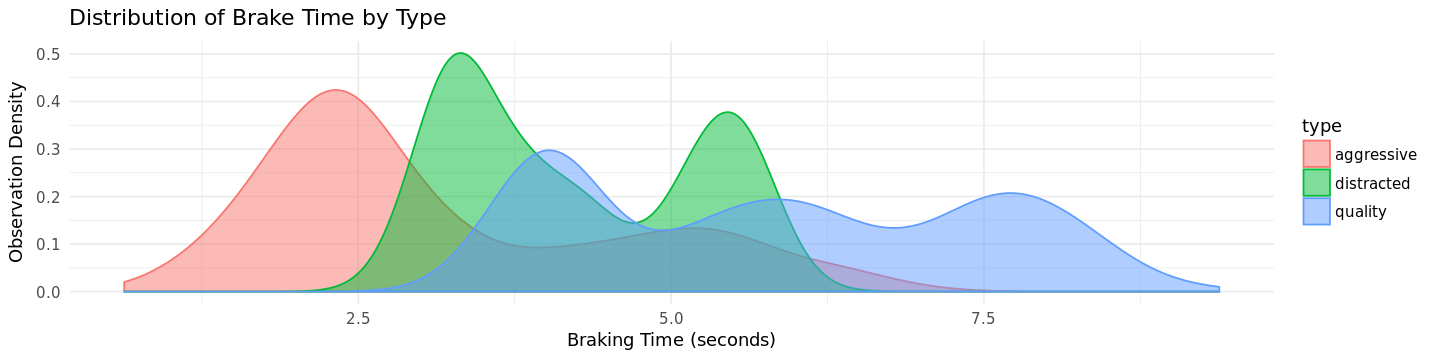

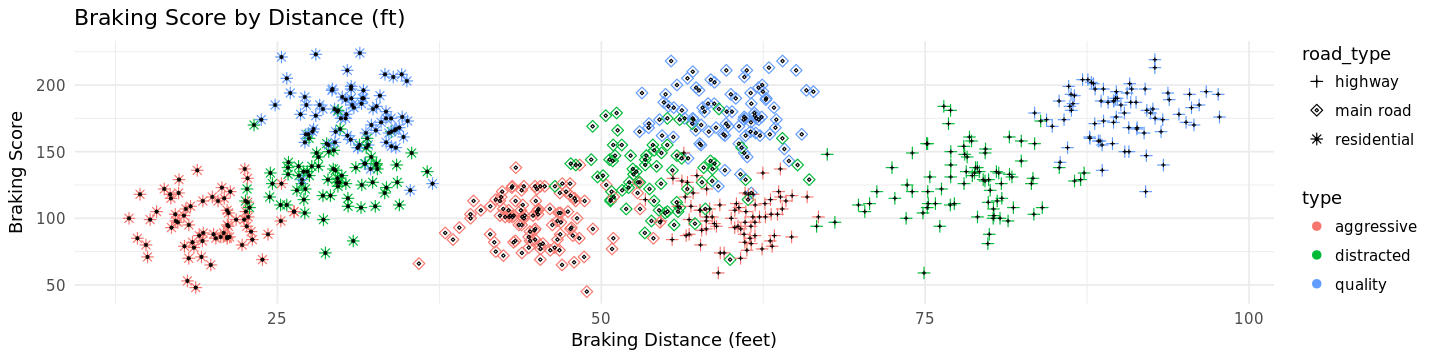

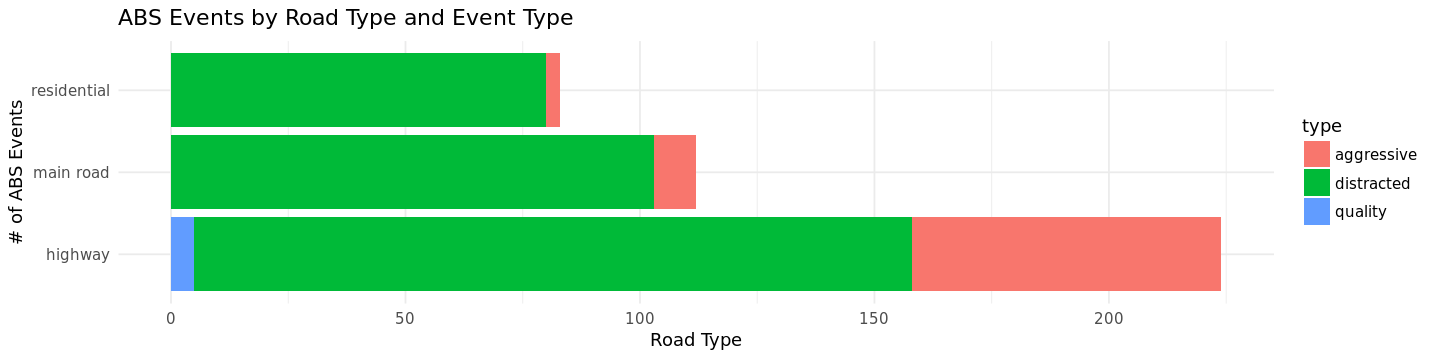

In [7]:
options(repr.plot.width = 12, repr.plot.height = 3)

ggplot(brakeEventDF, aes(x = brake_time_sec, color = type, fill = type)) + 
    geom_density(alpha = 0.5) +
    labs(x = "Braking Time (seconds)", y = "Observation Density", title = "Distribution of Brake Time by Type") +
    theme_minimal()

ggplot(sample_frac(brakeEventDF, .33), aes(x = brake_distance_ft, y = braking_score)) + 
    geom_point(aes(shape = road_type, color = type), size = 2) +
    scale_shape_manual(values=c(3, 5, 8)) +
    geom_point(color = 'black', size = 0.35, aes(shape = road_type)) +
    labs(x = "Braking Distance (feet)", y = "Braking Score", title = "Braking Score by Distance (ft)") +
    theme_minimal()

ggplot(aggDF, aes(x = road_type, y = abs_events)) + 
    geom_bar(aes(fill = type), stat = 'identity') + 
    coord_flip() +
    labs(x = "# of ABS Events", y = "Road Type", title = "ABS Events by Road Type and Event Type") +
    theme_minimal()

After visually inspecting the data, we see some clear grouping along the lines of event type, road type, and number of ABS events.  There is also an obvious linear relationship between brake score and brake time.  This historical data is clean enough to build a model from.

__________

<a id='ml'></a>


### Modeling

We can train a decision tree model on the historical brake event data.  It will learn the relationship between the various quantitative variables and the type of brake event, allowing us to classify new records as they come in.  In this case, we will be checking the behavior of drivers making warranty claims.

We have another data set to test the model on, so in this case we don't need to split into train and test sets.  The following cell trains the model and tests its accuracy.

In [8]:
install.packages("caTools")
library(caTools)
install.packages("randomForest")
library(randomForest)

Installing package into ‘/user-home/_global_/R’
(as ‘lib’ is unspecified)
Installing package into ‘/user-home/_global_/R’
(as ‘lib’ is unspecified)
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine



In [9]:
## Preserve VINs to add on after modeling
#vins <- brakeEventDF$VIN

## set the seed to make your partition reproductible
set.seed(22)
brakeEventDF$spl = sample.split(brakeEventDF,SplitRatio=0.7)

train=subset(brakeEventDF, brakeEventDF$spl==TRUE)
test=subset(brakeEventDF, brakeEventDF$spl==FALSE)

## Select columns for modeling
trainingDF <- select(train, type, brake_time_sec, brake_distance_ft, road_type, braking_score, 
                 brake_pressure20pct, brake_pressure40pct, brake_pressure60pct,
                 brake_pressure80pct, brake_pressure100pct, abs_event, travel_speed)

brakeEventModel <- randomForest(type ~ ., 
                                data = trainingDF,
                                ntree = 500,
                                proximity = TRUE)

## Load test set
#testingDF <-  read.csv(file = getObjectStorageFileWithCredentials_d7a568f8ac534bc48834f0e1762068f9("DataScienceforAutomotiveWorkshop", "testdata.csv"))

print("Confusion Matrix for Testing Data:")
table(predict(brakeEventModel, select(test, -VIN, -type)), test$type)

[1] "Confusion Matrix for Testing Data:"


            
             aggressive distracted quality
  aggressive        242          0       0
  distracted          1        231       1
  quality             0          2     273

The accuracy on this model is strong enough to give us some confidence in using it on new data.  

_________

<a id='export'></a>

### Model Export

We can export the decision tree model for use in our Shiny app.

In [13]:
saveRDS(object = brakeEventModel, file = "brakeEventModel.rds")

In [1]:
!ls

brakeEventModel.rds  historical_brake_eventsGM.csv  spark-warehouse  target


The model has successfully been written.  

________

### Conclusion

In this notebook we have quickly explored and visualized brake event data using R.  We've also built, tested, and exported a decision tree model that can be embedded in applications or used to create reports.  To see the Shiny app where this model is used on customers coming into the service bay, click on 'Tools --> RStudio' in the menu bar above.

_______


<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>